# Netflix recommender

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load data

In [2]:
ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')

# Filter the data to reduce the number of movies
seed = 6789
rng = np.random.RandomState(seed=seed)
left_ids = rng.choice(ml_movies_df['item_id'], size=90, replace=False)
left_ids = list(set(left_ids).union(set([1, 318, 1193, 1208, 1214, 1721, 2959, 3578, 4306, 109487])))

ml_ratings_df = ml_ratings_df.loc[ml_ratings_df['item_id'].isin(left_ids)]
ml_movies_df = ml_movies_df.loc[ml_movies_df['item_id'].isin(left_ids)]
ml_df = ml_df.loc[ml_df['item_id'].isin(left_ids)]

display(ml_movies_df.head(10))

print("Number of interactions left: {}".format(len(ml_ratings_df)))

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
143,171,Jeffrey (1995),Comedy|Drama
194,228,Destiny Turns on the Radio (1995),Comedy
199,233,Exotica (1994),Drama
230,267,Major Payne (1995),Comedy
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
313,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
379,435,Coneheads (1993),Comedy|Sci-Fi
419,481,Kalifornia (1993),Drama|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


Number of interactions left: 2761


# Stochastic Gradient Descent Netflix Recommender

In [3]:
from livelossplot import PlotLosses

from recommenders.recommender import Recommender


class NetflixRecommender(Recommender):
    """
    Collaborative filtering based on matrix factorization with the following choice of an optimizer:
      - Stochastic Gradient Descent (SGD),
      - Mini-Batch Gradient Descent (MBGD),
      - Alternating Least Squares (ALS).
    """

    def __init__(self, seed=6789, n_neg_per_pos=5, print_type=None, **params):
        super().__init__()
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.interactions_df = None
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        self.r = None
        self.most_popular_items = None
        
        self.n_neg_per_pos = n_neg_per_pos
        if 'optimizer' in params:
            self.optimizer = params['optimizer']
        else:
            self.optimizer = 'SGD'
        if 'n_epochs' in params:  # number of epochs (each epoch goes through the entire training set)
            self.n_epochs = params['n_epochs']
        else:
            self.n_epochs = 10
        if 'lr' in params:  # learning rate
            self.lr = params['lr']
        else:
            self.lr = 0.01
        if 'reg_l' in params:  # regularization coefficient
            self.reg_l = params['reg_l']
        else:
            self.reg_l = 0.1
        if 'embedding_dim' in params:
            self.embedding_dim = params['embedding_dim']
        else:
            self.embedding_dim = 8
        
        self.user_repr = None
        self.item_repr = None

        if 'should_recommend_already_bought' in params:
            self.should_recommend_already_bought = params['should_recommend_already_bought']
        else:
            self.should_recommend_already_bought = False
            
        self.validation_set_size = 0.2
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)  
        
        self.print_type = print_type

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by
            user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined
            by item_id and the item feature columns.
        """

        del users_df, items_df

        # Shift item ids and user ids so that they are consecutive

        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

        interactions_df = interactions_df.copy()
        interactions_df['item_id'] = interactions_df['item_id'].map(self.item_id_mapping)
        interactions_df['user_id'] = interactions_df['user_id'].map(self.user_id_mapping)

        # Get the number of items and users

        self.interactions_df = interactions_df
        n_users = np.max(interactions_df['user_id']) + 1
        n_items = np.max(interactions_df['item_id']) + 1

        # Get the user-item interaction matrix (mapping to int is necessary because of how iterrows works)
        r = np.zeros(shape=(n_users, n_items))
        for idx, interaction in interactions_df.iterrows():
            r[int(interaction['user_id'])][int(interaction['item_id'])] = 1

        self.r = r
        
        # Indicate positive interactions
        
        interactions_df['interacted'] = 1

        # Generate negative interactions
        negative_interactions = []

        i = 0
        while i < self.n_neg_per_pos * len(interactions_df):
            sample_size = 1000
            user_ids = self.rng.choice(np.arange(n_users), size=sample_size)
            item_ids = self.rng.choice(np.arange(n_items), size=sample_size)

            j = 0
            while j < sample_size and i < self.n_neg_per_pos * len(interactions_df):
                if r[user_ids[j]][item_ids[j]] == 0:
                    negative_interactions.append([user_ids[j], item_ids[j], 0])
                    i += 1
                j += 1
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        
        # Initialize user and item embeddings as random vectors (from Gaussian distribution)
        
        self.user_repr = self.rng.normal(0, 1, size=(r.shape[0], self.embedding_dim))
        self.item_repr = self.rng.normal(0, 1, size=(r.shape[1], self.embedding_dim))
        
        # Initialize losses and loss visualization
        
        if self.print_type is not None and self.print_type == 'live':
            liveloss = PlotLosses()

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        
        # Split the data
        
        interaction_ids = self.rng.permutation(len(interactions_df))
        train_validation_slice_idx = int(len(interactions_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]
        
        # Train the model
        
        for epoch in range(self.n_epochs):
            if self.print_type is not None and self.print_type == 'live':
                logs = {}
            
            # Train
            
            training_losses.clear()
            training_total_loss = 0.0
            batch_idx = 0
            for idx in training_ids:
                user_id = int(interactions_df.iloc[idx]['user_id'])
                item_id = int(interactions_df.iloc[idx]['item_id'])
                r_ui = interactions_df.iloc[idx]['interacted']
            
                e_ui = r_ui - np.dot(self.user_repr[user_id], self.item_repr[item_id])
                self.user_repr[user_id] = self.user_repr[user_id] \
                    + self.lr * (e_ui * self.item_repr[item_id] - self.reg_l * self.user_repr[user_id])
                self.item_repr[item_id] = self.item_repr[item_id] \
                    + self.lr * (e_ui * self.user_repr[user_id] - self.reg_l * self.item_repr[item_id])
                
                loss = e_ui**2
                training_total_loss += loss
                
                if self.print_type is not None and self.print_type == 'text':
                    print('\rEpoch: {}\tBatch: {}\tLast epoch - avg training loss: {:.2f} avg validation loss: {:.2f} loss: {}'.format(
                        epoch, batch_idx, last_training_total_loss, last_validation_total_loss, loss), end="")
                    
                batch_idx += 1
                
                training_losses.append(loss)
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            
            validation_losses.clear()
            validation_total_loss = 0.0
            for idx in validation_ids:
                user_id = int(interactions_df.iloc[idx]['user_id'])
                item_id = int(interactions_df.iloc[idx]['item_id'])
            
                e_ui = r[user_id, item_id] - np.dot(self.user_repr[user_id], self.item_repr[item_id])
                
                loss = e_ui**2
                validation_total_loss += loss

                validation_losses.append(loss)
                validation_avg_losses.append(np.mean(validation_losses))
                
            # Save and print epoch losses
            
            training_last_avg_loss = training_total_loss / len(training_ids)
            validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if self.print_type is not None and self.print_type == 'live' and epoch >= 3:
                # A bound on epoch prevents showing extremely high losses in the first epochs
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()

        # Find the most popular items for the cold start problem

        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index

    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which
            recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """

        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]

        # Handle users not in the training data

        # Map item ids

        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df.replace({'item_id': self.item_id_mapping}, inplace=True)

        # Generate recommendations

        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id in self.user_id_mapping:
                mapped_user_id = self.user_id_mapping[user_id]
                
                ids_list = items_df['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k
                scores = np.matmul(self.user_repr[mapped_user_id].reshape(1, -1), 
                                   self.item_repr[ids_list].T).flatten()
                
                # Choose n recommendations based on highest scores
                if not self.should_recommend_already_bought:
                    x_list = self.interactions_df.loc[
                        self.interactions_df['user_id'] == mapped_user_id]['item_id'].tolist()
                    scores[id_to_pos[x_list]] = -1e100

                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else:  # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df
    
    def get_user_repr(self, user_id):
        mapped_user_id = self.user_id_mapping[user_id]
        return self.user_repr[mapped_user_id]
    
    def get_item_repr(self, item_id):
        mapped_item_id = self.item_id_mapping[item_id]
        return self.item_repr[mapped_item_id]

## Quick test of the recommender (training)

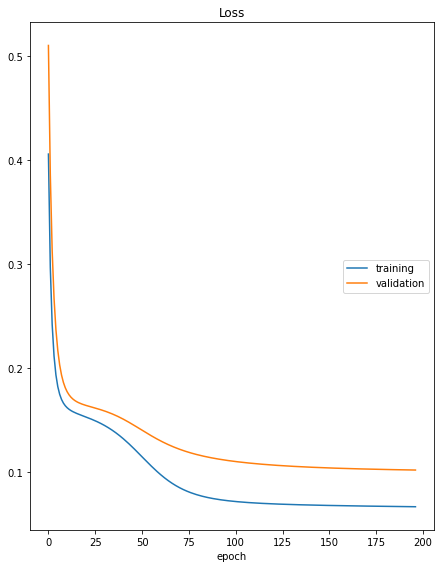

Loss
	training         	 (min:    0.067, max:    0.406, cur:    0.067)
	validation       	 (min:    0.102, max:    0.510, cur:    0.102)


In [4]:
netflix_recommender = NetflixRecommender(print_type='live', embedding_dim=8, n_epochs=200)
netflix_recommender.fit(ml_ratings_df, None, ml_movies_df)

## Quick test of the recommender (recommending)

In [5]:
recommendations = netflix_recommender.recommend(pd.DataFrame([[1], [4], [6]], columns=['user_id']), ml_movies_df, 10)

recommendations = pd.merge(recommendations, ml_movies_df, on='item_id', how='left')
print("Recommendations")
display(HTML(recommendations.to_html()))

Recommendations


,user_id,item_id,score,title,genres
0,1,4896,0.527700,Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),Adventure|Children|Fantasy
1,1,41566,0.433971,"Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)",Adventure|Children|Fantasy
2,1,145,0.387873,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller
3,1,6537,0.383789,Terminator 3: Rise of the Machines (2003),Action|Adventure|Sci-Fi
4,1,6502,0.357302,28 Days Later (2002),Action|Horror|Sci-Fi
5,1,355,0.342760,"Flintstones, The (1994)",Children|Comedy|Fantasy
6,1,5673,0.339795,Punch-Drunk Love (2002),Comedy|Drama|Romance
7,1,435,0.325866,Coneheads (1993),Comedy|Sci-Fi
8,1,4890,0.308742,Shallow Hal (2001),Comedy|Fantasy|Romance
9,1,481,0.232846,Kalifornia (1993),Drama|Thriller


## User and item representations

In [123]:
user_id = 1
user_repr = netflix_recommender.get_user_repr(user_id=user_id)
print("User id={}".format(user_id))
print(user_repr)
print()

print("User watched")
print(ml_df.loc[ml_df['user_id'] == user_id, 'title'].tolist())
print()

print('User history item representations')
for item_id in ml_df.loc[ml_df['user_id'] == user_id, 'item_id'].tolist():
    item_repr = netflix_recommender.get_item_repr(item_id=item_id)
    print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
    print(item_repr)
    score = np.dot(user_repr, item_repr)
    print("Score={:.6f}".format(score))
    print()

print("===============")
    
item_id = 145
item_repr = netflix_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Score={:.6f}".format(score))
print()

item_id = 171
item_repr = netflix_recommender.get_item_repr(item_id=item_id)
print("Item id = {}\titem title = {}".format(item_id, ml_movies_df.loc[ml_movies_df['item_id'] == item_id, 'title'].iloc[0]))
print(item_repr)
score = np.dot(user_repr, item_repr)
print("Score={:.6f}".format(score))

User id=1
[-0.02139117  0.06550183  0.2885759  -0.06954907 -0.01076932 -0.18392664
 -0.40554771  0.12874623]

User watched
['Independence Day (a.k.a. ID4) (1996)', 'Grosse Pointe Blank (1997)', 'Ladyhawke (1985)']

User history item representations
Item id = 780	item title = Independence Day (a.k.a. ID4) (1996)
[-0.50389334  0.70172008  0.39235194 -0.10816701  0.0942051  -0.61101266
 -0.59356283  0.27160778]
Score=0.564543

Item id = 1500	item title = Grosse Pointe Blank (1997)
[-0.22653614  0.34098645  0.56580781 -0.25493768  0.07464091 -0.11979516
 -0.50885162  0.14059538]
Score=0.453885

Item id = 3479	item title = Ladyhawke (1985)
[ 0.01901309  0.20501534  0.23839305 -0.06010713  0.08316735 -0.1498871
 -0.33048343  0.20112703]
Score=0.272591

Item id = 145	item title = Bad Boys (1995)
[-0.20925097  0.43954442  0.18606477 -0.28588045 -0.24253887 -0.19554464
 -0.67368598  0.2782696 ]
Score=0.454459

Item id = 171	item title = Jeffrey (1995)
[-0.10674823  0.06194838 -0.00138661 -0.044

# Training-test split evaluation

In [74]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

In [116]:
netflix_recommender = NetflixRecommender(n_epochs=150)

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.266234,0.558442,0.753247,0.987013,0.266234,0.433592,0.513507,0.590394


In [124]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.181818,0.311688,0.402597,0.551948,0.181818,0.257806,0.294682,0.34147


In [125]:
from recommenders.tfidf_recommender import TFIDFRecommender

tfidf_recommender = TFIDFRecommender()

tfidf_tts_results = [['TFIDFRecommender'] + list(evaluate_train_test_split_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df))]

tfidf_tts_results = pd.DataFrame(
    tfidf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,TFIDFRecommender,0.025974,0.090909,0.136364,0.318182,0.025974,0.064393,0.083685,0.140799


In [126]:
tts_results = pd.concat([netflix_tts_results, amazon_tts_results, tfidf_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.266234,0.558442,0.753247,0.987013,0.266234,0.433592,0.513507,0.590394
1,AmazonRecommender,0.181818,0.311688,0.402597,0.551948,0.181818,0.257806,0.294682,0.341470
2,TFIDFRecommender,0.025974,0.090909,0.136364,0.318182,0.025974,0.064393,0.083685,0.140799


# Leave-one-out evaluation

In [30]:
from evaluation_and_testing.testing import evaluate_leave_one_out_implicit

In [31]:
netflix_recommender = NetflixRecommender(n_epochs=10)

netflix_loo_results = [['NetflixRecommender'] + list(evaluate_leave_one_out_implicit(
    netflix_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

netflix_loo_results = pd.DataFrame(
    netflix_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_loo_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,UserBasedCosineNearestNeighborsRecommender,0.096667,0.146667,0.186667,0.306667,0.096667,0.124285,0.140782,0.178962


In [35]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_loo_results = [['AmazonRecommender'] + list(evaluate_leave_one_out_implicit(
    amazon_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

amazon_loo_results = pd.DataFrame(
    amazon_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_loo_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.166667,0.256667,0.32,0.426667,0.166667,0.219086,0.245486,0.279978


In [36]:
tfidf_recommender = TFIDFRecommender()

tfidf_loo_results = [['TFIDFRecommender'] + list(evaluate_leave_one_out_implicit(
    tfidf_recommender, ml_ratings_df.loc[:, ['user_id', 'item_id']], ml_movies_df, max_evals=300, seed=6789))]

tfidf_loo_results = pd.DataFrame(
    tfidf_loo_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(tfidf_loo_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,TFIDFRecommender,0.006667,0.053333,0.123333,0.233333,0.006667,0.033491,0.062178,0.096151


In [37]:
loo_results = pd.concat([netflix_loo_results, amazon_loo_results, tfidf_loo_results]).reset_index(drop=True)
display(HTML(loo_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,UserBasedCosineNearestNeighborsRecommender,0.096667,0.146667,0.186667,0.306667,0.096667,0.124285,0.140782,0.178962
1,UserBasedCosineNearestNeighborsRecommender,0.100000,0.150000,0.180000,0.313333,0.100000,0.127182,0.139518,0.181748
2,UserBasedCosineNearestNeighborsRecommender,0.266667,0.420000,0.513333,0.650000,0.266667,0.357736,0.396033,0.440599
3,UserBasedCosineNearestNeighborsRecommender,0.173333,0.280000,0.336667,0.420000,0.173333,0.234522,0.257759,0.284723
4,AmazonRecommender,0.166667,0.256667,0.320000,0.426667,0.166667,0.219086,0.245486,0.279978
5,TFIDFRecommender,0.006667,0.053333,0.123333,0.233333,0.006667,0.033491,0.062178,0.096151
